In [11]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns

plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'normal'

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression


In [12]:
# loading the data
original_df = pd.read_csv(
    '/home/mwawaka/PycharmProjects/pythonProject1/CAT/data/NSE_data_all_stocks_2022_jan_to_may.csv')

# Copy of the dataframe
df = original_df.copy()

In [51]:
#convert the date column from type object to type Date
df['Date'] = pd.DatetimeIndex(df['Date'])
df.set_index('Date', inplace=True)

df['Day Price'] = pd.to_numeric(df['Day Price'],errors="coerce")

# Filling the null values with estimate values based on existing data 
df['Day Price'].interpolate(inplace=True)

df['Day Price'].isna().sum()

0

/usr/lib/python3.11/random.py:374: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return seq[self._randbelow(len(seq))]


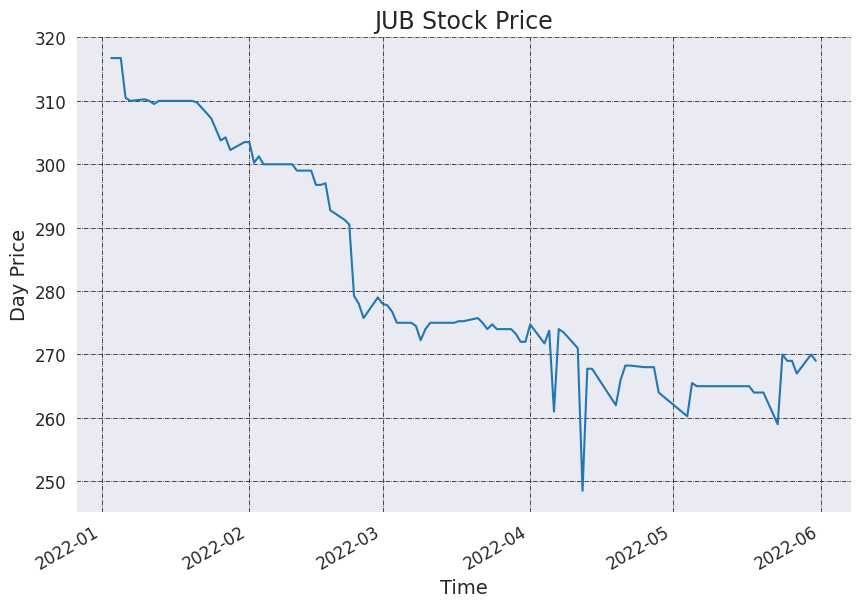

In [68]:
# Time series for Stocks for different companies

# Choosing a random company
company_code = random.choice(df.Code)
company_df = df.loc[df['Code']==company_code]
# Plotting the data
company_df['Day Price'].plot(figsize=(10, 7))
plt.title(company_code+" Stock Price", fontsize=17)
plt.ylabel('Day Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

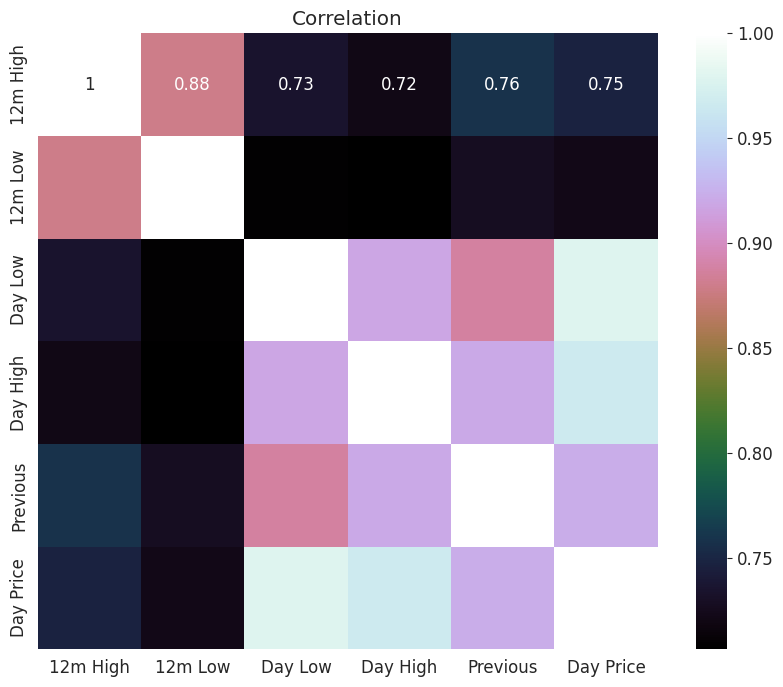

LBTY


In [14]:
# Class Data Preprocessor
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, type_cast=None, to_scale=None, to_return=None, company_code=None):
        self.type_cast = type_cast
        self.to_scale = to_scale
        self.to_return = to_return
        self.company_code = company_code

    def __process(self, dataframe):
        data_scaler = StandardScaler()
        for column_name in self.type_cast:
            dataframe[column_name] = pd.to_numeric(dataframe[column_name])
        dataframe[self.to_scale] = data_scaler.fit_transform(dataframe[self.to_scale])
        return dataframe[self.to_return]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        company_df = X[X['Code'] == self.company_code].reset_index(drop=True)

        processed_df = self.__process(company_df)

        return processed_df

    # using the preprocessor


# Chooses a random company code 
# random_company_code = random.choice(df.Code)

data = DataPreprocessor(
    type_cast=['Day Price', 'Day High', 'Day Low', '12m High', '12m Low'],
    to_scale=['Previous', 'Day High', 'Day Low', '12m High', '12m Low'],
    to_return=['Code', '12m High', '12m Low', 'Day Low', 'Day High', 'Previous', 'Day Price'],
    company_code='LKL')
transformed_df = data.fit_transform(df)

dff = transformed_df.drop(['Code'], axis=1)
X = dff.drop(['Day Price'], axis=1)
y = dff['Day Price']

# Visualizations
cor_mat = dff.corr()
plt.figure(figsize=(10, 8))
plt.title('Correlation')
sns.heatmap(cor_mat, cmap='cubehelix', annot=True)
plt.show()



In [15]:
# splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape, y_test.shape

((21, 5), (21,))

Accuracy:99.41297970459925
MAE:0.01860076317230766
RMSE:0.027417441416635352


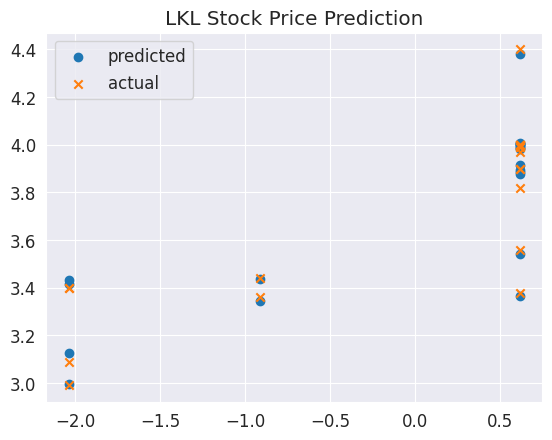

In [49]:
linear = LinearRegression()

linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

scores = linear.score(X_test, y_test)
accuracy = scores * 100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Accuracy:{accuracy}')
print(f'MAE:{mae}')
print(f'RMSE:{np.sqrt(mse)}')

results = pd.DataFrame(data={
    'Actual': y_test,
    'Predicted': y_pred
})
results.reset_index(drop=True)

day_high = X_test['12m Low']

plt.scatter(x=day_high, y=y_pred, label='predicted', marker='o')
plt.scatter(x=day_high, y=y_test, label='actual', marker='x')


plt.title('LKL' + ' Stock Price Prediction')

plt.legend()
plt.show()

plt.show()

In [17]:
# feature selection
selector = SelectKBest(score_func=f_regression, k=2)
selector.fit(X_train, y_train)
print('Number of input features:', selector.n_features_in_)
print('Input features Names  :', selector.feature_names_in_)
print('Input features scores :', selector.scores_)
print('Input features pvalues:', selector.pvalues_)
print('Output features Names :', selector.get_feature_names_out())

# Based on the output ['Day Low','Day High'] have a huge impact on the classes

# selecting features based on f-score
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



Number of input features: 5
Input features Names  : ['12m High' '12m Low' 'Day Low' 'Day High' 'Previous']
Input features scores : [  93.48490021   72.58038671 1680.46018936 1127.67555507  455.94202242]
Input features pvalues: [4.84103247e-15 8.45042865e-13 5.31200103e-55 1.58316186e-48
 1.49169961e-34]
Output features Names : ['Day Low' 'Day High']


In [18]:
# Model train
linear = LinearRegression()

linear.fit(X_train_selected, y_train)
y_pred = linear.predict(X_test_selected)

scores = linear.score(X_test_selected, y_test)

accuracy = scores * 100
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy:{scores}')
print(f'MAE:{mae}')

results

Accuracy:0.9953963222987559
MAE:0.01499315992699551


,Actual,Predicted
30,4.00,3.995606
67,3.38,3.364826
62,3.56,3.539667
47,3.90,3.876871
42,4.00,4.004458
40,4.00,3.993414
90,3.44,3.437096
45,3.90,3.886397
10,4.00,4.002986
0,3.97,3.983290


In [19]:
# Perform k-fold cross-validation for the L. regression model (let's say k=5)
cross_val_scores = cross_val_score(linear, X, y, cv=5, scoring='neg_mean_squared_error')

print("Linear Regression Cross-Validation Scores:", end=' ')
print(cross_val_scores)

average_score = np.mean(cross_val_scores)
print(f"\nAverage Performance Metric: {average_score:}")

Linear Regression Cross-Validation Scores: [-0.00095407 -0.00106318 -0.00098015 -0.00389668 -0.00112589]

Average Performance Metric: -0.001603993015156019
